# Goals

* Introduction on accssing data in the Tahoe-100 tiledb-soma database. 

# Setup

Set the path to the database. The database can be cloud hosted (AWS S3 or Google Cloud Storage) or local.

In [2]:
db_uri = "gs://arc-ctc-tahoe100/2025-02-25/tiledb-soma/"
#db_uri = "/processed_datasets/scRecount/tahoe/tiledb-soma-mini/"

Import the following packages. You can install all of them via `pip` and/or `conda`.

> Note: `plotnine` is only necessary if you want to plot the data. You can also use `matplotlib` or any other plotting library.

In [3]:
import os
import concurrent.futures
from typing import Optional, List, Tuple

import pandas as pd
import scanpy as sc
import scipy.sparse as sp
import plotnine as pn
import pyarrow as pa
import pyarrow.compute as pc
import anndata
import tiledbsoma
import tiledbsoma.io


In [4]:
# [optional] asthetics settings
pn.theme_set(pn.theme_bw())

## Helper functions

The following function uses chunked reading instead of reading in all of the data via `.concat`. 
This substantially reduces the memory usage and compute time.

In [5]:
def get_obs(
        db_uri: str,
        columns: Optional[List[str]] = None,
        obs_query: Optional[tiledbsoma.AxisQuery] = None,
        axis: str = "RNA",
        group_by: Optional[List[str]] = None,
        agg_name: str = "count_all"
    ) -> pd.DataFrame:
    """
    Retrieve the obs table from a tiledbsoma Experiment.
    
    If group_by is provided, aggregated counts by the specified grouping columns are returned.
    Otherwise, the full obs subset with the specified columns is returned.
    
    Parameters:
      db_uri: URI for the database.
      columns: List of column names to retrieve (required if group_by is None).
      obs_query: Optional AxisQuery to filter the obs data.
      axis: The axis to query (default "RNA").
      group_by: Optional list of columns to group by for aggregation.
      agg_name: Name for the aggregated count column (default "count_all").
    
    Returns:
      A pandas DataFrame containing either the subset of obs data or the aggregated counts.
    """
    if group_by is not None:
        # When grouping, we only need the group_by columns.
        group_cols = group_by
        chunk_results: List[pd.DataFrame] = []
        with tiledbsoma.Experiment.open(db_uri) as exp:
            # Use axis_query if provided.
            if obs_query is not None:
                try:
                    reader = exp.axis_query(axis, obs_query=obs_query).obs(column_names=group_cols)
                except TypeError:
                    reader = exp.axis_query(axis, obs_query=obs_query).obs()
                chunk_iter = reader
            else:
                chunk_iter = exp.obs.read(column_names=group_cols)
            # Process each chunk.
            for chunk in chunk_iter:
                if chunk.num_rows == 0:
                    continue
                df_chunk = chunk.to_pandas()
                # Group and count within this chunk.
                df_group = df_chunk.groupby(group_cols, as_index=False).size().rename(columns={"size": agg_name})
                chunk_results.append(df_group)
        if not chunk_results:
            return pd.DataFrame(columns=group_cols + [agg_name])
        # Combine chunk results and re-aggregate to get overall counts.
        df_all = pd.concat(chunk_results, ignore_index=True)
        df_final = df_all.groupby(group_cols, as_index=False)[agg_name].sum()
        return df_final.sort_values(by=agg_name, ascending=False)
    else:
        # Without grouping, ensure columns is provided.
        if columns is None:
            raise ValueError("When group_by is not specified, the 'columns' parameter must be provided.")
        chunks: List[pd.DataFrame] = []
        with tiledbsoma.Experiment.open(db_uri) as exp:
            if obs_query is not None:
                try:
                    reader = exp.axis_query(axis, obs_query=obs_query).obs(column_names=columns)
                except TypeError:
                    reader = exp.axis_query(axis, obs_query=obs_query).obs()
                chunk_iter = reader
            else:
                chunk_iter = exp.obs.read(column_names=columns)
            for chunk in chunk_iter:
                if chunk.num_rows == 0:
                    continue
                df_chunk = chunk.to_pandas()[columns]
                chunks.append(df_chunk)
        if not chunks:
            return pd.DataFrame(columns=columns)
        return pd.concat(chunks, ignore_index=True)


The following function converts portions of the tiledb-soma database to anndata objects.
Chunking of the count matrix is performed in parallel (see `max_workers`).

In [8]:
def group_contiguous(sorted_ids: List[int]) -> List[Tuple[int, int, List[int]]]:
    """
    Group a sorted list of integers into contiguous blocks.
    Each block is returned as a tuple (start, end, group_ids),
    where group_ids is the list of consecutive integers, and the block
    covers indices from start to end-1.
    """
    groups = []
    if not sorted_ids:
        return groups
    current = [sorted_ids[0]]
    for i in sorted_ids[1:]:
        if i == current[-1] + 1:
            current.append(i)
        else:
            groups.append((current[0], current[-1] + 1, current.copy()))
            current = [i]
    groups.append((current[0], current[-1] + 1, current.copy()))
    return groups

def read_block(ms_array, block_range: Tuple[int, int], group_ids: List[int]) -> sp.csr_matrix:
    """
    Read a contiguous slice of the measurement array and extract only the rows
    corresponding to group_ids.
    
    The TileDB array returns a full matrix with data in the original row positions,
    so we use the original group_ids for indexing rather than computing relative indices.
    """
    start, end = block_range
    
    # Read and convert to sparse matrix
    block_tensor = ms_array.read(coords=(slice(start, end), slice(None)))
    block_sparse = block_tensor.coos().concat().to_scipy().tocsr()
    
    # Extract rows using original group_ids
    return block_sparse[group_ids, :]

def get_anndata(
    db_uri: str,
    obs_query: Optional[tiledbsoma.AxisQuery] = None,
    measurement_name: str = "RNA",
    X_name: str = "X",
    obs_columns: Optional[List[str]] = None,
    max_workers: int = 12
) -> anndata.AnnData:
    """
    Retrieve a subset of an experiment as an AnnData object, filtering the measurement
    (X) on-disk by reading only the rows corresponding to the obs query's 'soma_joinid' values.
    
    In addition, the function reads the var DataFrame from the measurement so that
    the returned AnnData object contains full feature metadata.
    
    Steps:
      1. Read obs metadata (optionally in chunks) and filter it via obs_query.
      2. Extract the 'soma_joinid' values from obs and group them into contiguous blocks.
      3. Use a ThreadPoolExecutor to read each contiguous block (via slicing) concurrently.
      4. Vertically stack the resulting blocks and reorder rows to match the original obs order.
      5. Read the var DataFrame from the measurement.
      6. Construct an AnnData object with obs, var, and the sparse X matrix.
    
    Parameters:
      db_uri (str): URI of the TileDB-SOMA experiment.
      obs_query (Optional[tiledbsoma.AxisQuery]): Query to filter observations.
      measurement_name (str): Name of the measurement (e.g. "RNA").
      X_name (str): Name of the measurement matrix (e.g. "X").
      obs_columns (Optional[List[str]]): List of columns to retrieve from obs.
      chunk_obs (bool): Whether to read obs metadata in chunks.
      max_workers (int): Maximum number of threads for parallel block reads.
    
    Returns:
      anndata.AnnData: The filtered AnnData object with a sparse X and complete var metadata.
    """
    import sys
    print("Reading obs metadata...", file=sys.stderr)
    # --- Read obs metadata ---
    if obs_columns is None:
        obs_columns = ["soma_joinid"]
    obs_df = get_obs(db_uri, columns=obs_columns, obs_query=obs_query, axis=measurement_name)
    
    # --- Ensure 'soma_joinid' exists and extract join IDs ---
    if "soma_joinid" not in obs_df.columns:
        raise ValueError("The obs metadata must include the 'soma_joinid' column.")
    required_ids = obs_df["soma_joinid"].tolist()
    sorted_ids = sorted(required_ids)
    groups = group_contiguous(sorted_ids)
    print(f"Found {len(groups)} contiguous blocks.", file=sys.stderr)
    
    print("Reading measurement data by contiguous blocks in parallel...", file=sys.stderr)
    block_list = []
    with tiledbsoma.Experiment.open(db_uri) as exp:
        ms_obj = exp.ms[measurement_name]
        if X_name not in ms_obj:
            available = list(ms_obj.keys())
            raise ValueError(f"Measurement '{measurement_name}' does not contain layer '{X_name}'. "
                             f"Available layers: {available}")
        ms_layer = ms_obj[X_name]
        if isinstance(ms_layer, tiledbsoma.Collection):
            keys = list(ms_layer.keys())
            ms_array = ms_layer["data"] if "data" in keys else ms_layer[keys[0]]
        else:
            ms_array = ms_layer
        
        with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
            future_to_block = {
                executor.submit(read_block, ms_array, (start, end), group_ids): (start, end, group_ids)
                for (start, end, group_ids) in groups
            }
            for future in concurrent.futures.as_completed(future_to_block):
                block_info = future_to_block[future]
                try:
                    block_matrix = future.result()
                    #print(block_matrix); return None
                    block_list.append((block_info[2], block_matrix))
                    if len(block_list) % 10 == 0:
                        print(f"  Processed {len(block_list)} blocks.", file=sys.stderr)
                except Exception as e:
                    raise ValueError(f"Error reading block {block_info[0]} to {block_info[1]}") from e
    
    if not block_list:
        raise ValueError("No measurement data was read.")
    
    print("Stacking blocks...", file=sys.stderr)
    block_list.sort(key=lambda x: x[0][0])  
    blocks = [blk for (_, blk) in block_list]
    # Now blocks are (cells x genes), verify dimensions match
    n_genes = blocks[0].shape[1]  # Check number of genes (columns) instead
    for i, block in enumerate(blocks):
        if block.shape[1] != n_genes:
            raise ValueError(f"Block {i} has {block.shape[1]} genes but expected {n_genes}")
    # Stack vertically since blocks are already (cells x genes)
    X_filtered = sp.vstack(blocks).tocsr() 
    
    print("Reading var metadata...", file=sys.stderr)
    with tiledbsoma.Experiment.open(db_uri) as exp:
        var_reader = exp.ms[measurement_name].var.read()
        var_df = var_reader.concat().to_pandas()
    
    print("Creating AnnData object...", file=sys.stderr)
    adata = anndata.AnnData(X_filtered, obs=obs_df, var=var_df)
    return adata

# Obs data

* `obs` = "cells"

In [7]:
# get obs DataFrame schema 
with tiledbsoma.open(db_uri) as exp:
    print(exp.obs.schema)

SOMAError: Error opening array: 'gs://arc-ctc-tahoe100/2025-02-25/tiledb-soma/obs'
  [TileDB::Array] Error: ArrayDirectory: [TileDB::GCS] Error: Read object failed on: gs://arc-ctc-tahoe100/2025-02-25/tiledb-soma/obs/__schema/__1738669614178_1738669614178_1ca907d5100129c081d7c52489660e69 (Retry policy exhausted, with a last message of PerformWork() - CURL error [35]=SSL connect error)

### Cell counts per sample

Sum the obs (cell) counts per sample ID.

In [18]:
counts = get_obs(db_uri, group_by=["sample"], agg_name="count_all")
print(counts.shape)
counts.head()

(96, 2)


/tmp/ipykernel_906626/4012524464.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/tmp/ipykernel_906626/4012524464.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


sample  count_all
30  smp_1717     124099
31  smp_1718     117306
32  smp_1719     114870
44  smp_1731     101200
42  smp_1729     101119

In [19]:
# total obs (cells) in the database
counts["count_all"].sum()

4705402

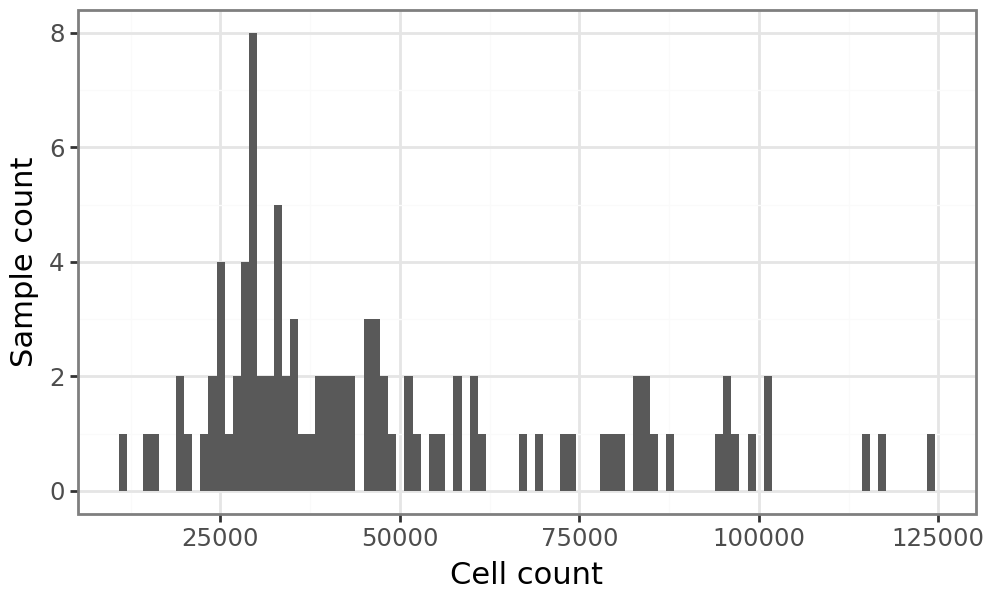

In [20]:
# plot cells per sample
p = (
    pn.ggplot(counts, pn.aes(x="count_all")) + 
    pn.geom_histogram(bins=100) +
    pn.labs(x="Cell count", y="Sample count") +
    pn.theme(figure_size=(5,3))
    )
p

### Cell counts per drug

In [10]:
counts = get_obs(db_uri, group_by=["drug"])
print(counts.shape)
counts.head()

/tmp/ipykernel_851927/4012524464.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


(380, 2)


/tmp/ipykernel_851927/4012524464.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


drug  count_all
28                   DMSO_TF    2330156
4                  Adagrasib    1504078
104                 Afatinib     734761
187  Almonertinib (mesylate)     622410
114              Binimetinib     574740

In [11]:
# filter to top 30 drugs
top_drugs = counts.sort_values('count_all', ascending=False)["drug"].unique()[:30]
counts_f = counts[counts["drug"].isin(top_drugs)]
counts_f.shape
counts_f.head()

drug  count_all
28                   DMSO_TF    2330156
4                  Adagrasib    1504078
104                 Afatinib     734761
187  Almonertinib (mesylate)     622410
114              Binimetinib     574740

/tmp/ipykernel_851927/365855227.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


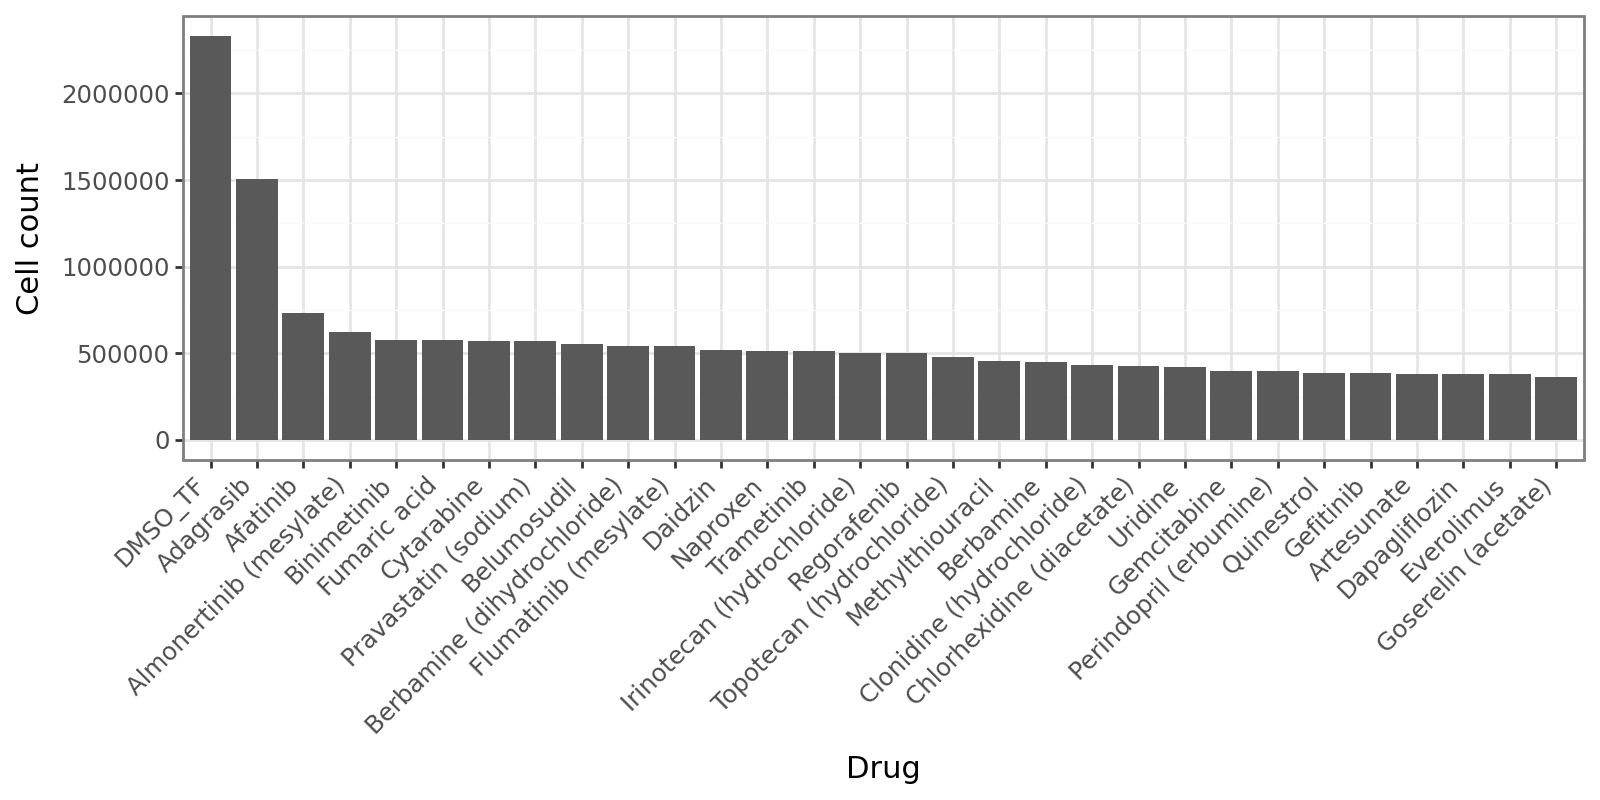

In [12]:
# plot cells per drug

## sort drugs by cell count
counts_f['drug'] = pd.Categorical(
    counts_f['drug'], 
    categories=counts_f.sort_values('count_all', ascending=False)['drug'].unique().tolist(), 
    ordered=True
)

## plot
p = (
    pn.ggplot(counts_f, pn.aes(x="drug", y="count_all")) + 
    pn.geom_col() +
    pn.labs(x="Drug", y="Cell count") +
    pn.theme(
        figure_size=(8,4),
        axis_text_x=pn.element_text(angle=45, hjust=1)
    ))
p

### Transcripts (UMIs) per cell

In [13]:
# read in the obs data
counts = get_obs(db_uri, group_by=["tscp_count"])
print(counts.shape)
counts.head()

(47042, 2)


tscp_count  count_all
1071        1232      46791
1046        1207      46706
1068        1229      46680
1063        1224      46676
1125        1286      46636

In [14]:
# stats
with pd.option_context('display.float_format', '{:.0f}'.format):
    print(counts["tscp_count"].describe())

count    47042
mean     25206
std      16595
min        161
25%      11921
50%      23682
75%      35766
max     235188
Name: tscp_count, dtype: float64


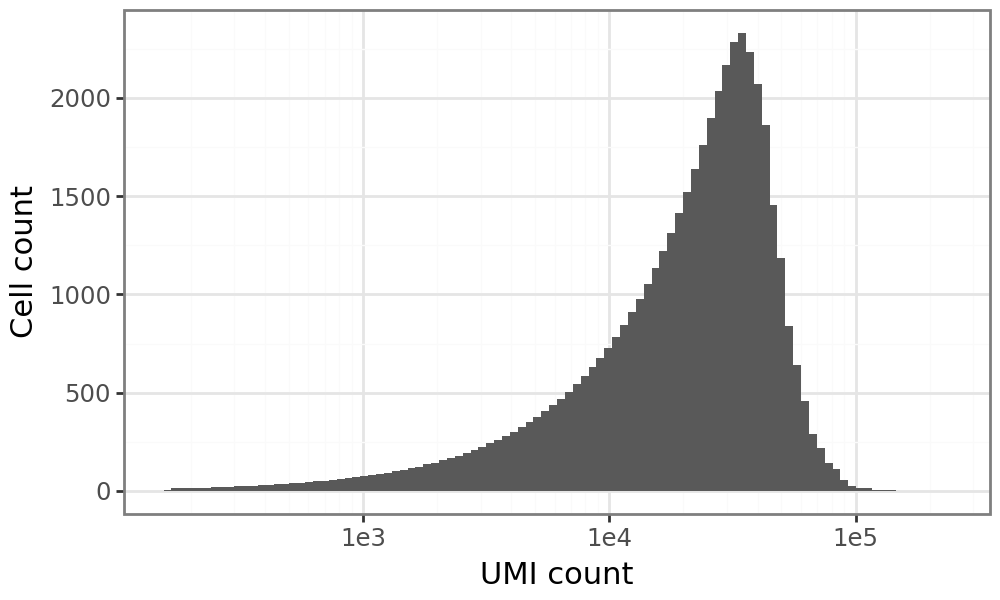

In [15]:
# plot transcripts per cell 
p = (
    pn.ggplot(counts, pn.aes(x="tscp_count")) + 
    pn.geom_histogram(bins=100) +
    pn.scale_x_log10() +
    pn.labs(x="UMI count", y="Cell count") +
    pn.theme_bw() +
    pn.theme(figure_size=(5,3))
    )
p

### Gene counts per cell

Number of genes per cell with non-zero UMI counts.

In [16]:
# read in the obs data
counts = get_obs(db_uri, columns=["gene_count"])
print(counts.shape)
counts.head()

(100648790, 1)


gene_count
0        1154
1        1132
2         916
3        1857
4         731

In [17]:
# stats
with pd.option_context('display.float_format', '{:.0f}'.format):
    print(counts["gene_count"].describe())

count   100648790
mean         1451
std           812
min           115
25%           898
50%          1255
75%          1776
max         14153
Name: gene_count, dtype: float64


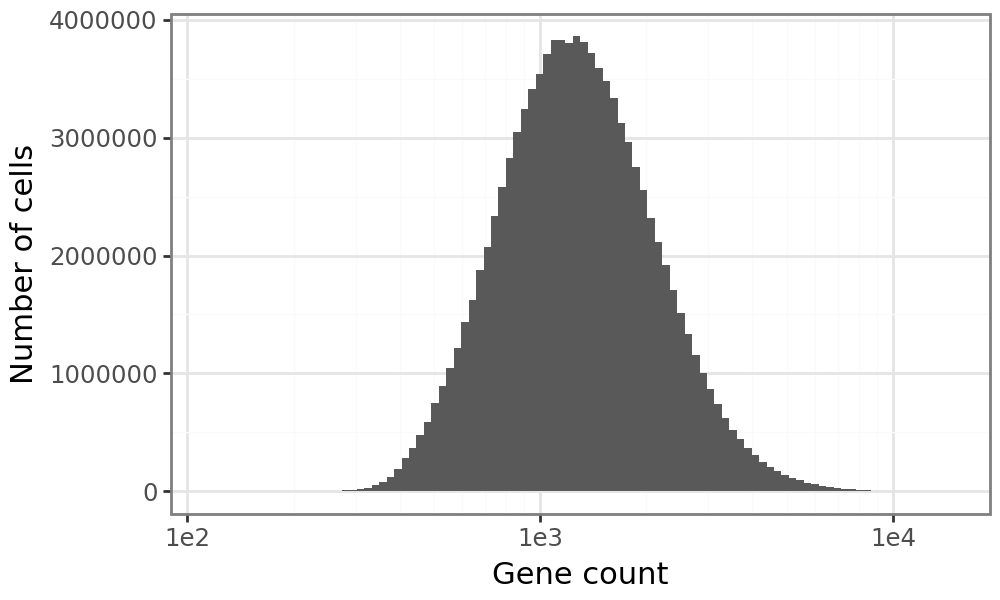

In [18]:
# plot reads per gene (barcode)
p = (
    pn.ggplot(counts, pn.aes(x="gene_count")) + 
    pn.geom_histogram(bins=100) +
    pn.scale_x_log10() +
    pn.labs(x="Gene count", y="Number of cells") +
    pn.theme_bw() +
    pn.theme(figure_size=(5,3))
    )
p

## Queries

Return only certain portions of the obs data

In [19]:
df = get_obs(db_uri, columns=["sample"], group_by=["sample"])
df.head()

/tmp/ipykernel_851927/4012524464.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/tmp/ipykernel_851927/4012524464.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


sample  count_all
1250  smp_2553     215364
1340  smp_2643     202116
202   smp_2177     196600
1310  smp_2613     195537
1335  smp_2638     192968

In [20]:
# Return certain samples
obs_query = tiledbsoma.AxisQuery(value_filter='sample in ["smp_2743", "smp_2643"]')
df = get_obs(db_uri, columns=["sample"], obs_query=obs_query)
print(df.shape)
df.head()

(258506, 1)


sample
0  smp_2743
1  smp_2743
2  smp_2743
3  smp_2743
4  smp_2743

In [21]:
# Cell count after filtering out cells with low UMI counts
obs_query = tiledbsoma.AxisQuery(value_filter='tscp_count >= 5000')
df = get_obs(db_uri, columns=["sample"], obs_query=obs_query, group_by=["sample"])
print(f"Number of cells: {df['count_all'].sum()}")

/tmp/ipykernel_851927/4012524464.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/tmp/ipykernel_851927/4012524464.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


Number of cells: 6923499


# Variables

* `var` = "genes"

In [22]:
# get var DataFrame schema
with tiledbsoma.open(db_uri) as exp:
    print(exp.ms["RNA"].var.schema)

soma_joinid: int64 not null
gene_name: large_string
var_id: large_string
organism: large_string


In [23]:
# read in the var level data
with tiledbsoma.Experiment.open(db_uri) as exp:
    df_var = (
        exp.ms["RNA"]
        .var.read()
        .concat()
        .to_pandas()
    )
df_var

soma_joinid        gene_name           var_id      organism
0                0           TSPAN6  ENSG00000000003  Homo_sapiens
1                1             TNMD  ENSG00000000005  Homo_sapiens
2                2             DPM1  ENSG00000000419  Homo_sapiens
3                3            SCYL3  ENSG00000000457  Homo_sapiens
4                4         C1orf112  ENSG00000000460  Homo_sapiens
...            ...              ...              ...           ...
62705        62705  ENSG00000291313  ENSG00000291313  Homo_sapiens
62706        62706  ENSG00000291314  ENSG00000291314  Homo_sapiens
62707        62707  ENSG00000291315  ENSG00000291315  Homo_sapiens
62708        62708  ENSG00000291316  ENSG00000291316  Homo_sapiens
62709        62709          TMEM276  ENSG00000291317  Homo_sapiens

[62710 rows x 4 columns]

# Convert to anndata

In [ ]:
# extract a  samples
obs_query = tiledbsoma.AxisQuery(value_filter='sample in ["smp_2743"]')
adata = get_anndata(db_uri, obs_query=obs_query, measurement_name="RNA", X_name="X", max_workers=12, obs_columns=["sample"])
adata

Reading obs metadata...


In [ ]:
# check count matrix
for axis,name in zip(range(2), ("cells per gene", "genes per cell")):
    print(f"-- {name} --")
    print(pd.DataFrame(adata.X.getnnz(axis=axis)).describe())
    print()

In [30]:
# extract a couple of samples
#obs_query = tiledbsoma.AxisQuery(value_filter='sample in ["smp_2743"]')
obs_query = tiledbsoma.AxisQuery(value_filter='sample in ["smp_1717"]')
adata1 = get_anndata(db_uri, obs_query=obs_query, measurement_name="RNA", X_name="X", max_workers=12)
adata1

Reading obs metadata...
Found 105 contiguous blocks.
Reading measurement data by contiguous blocks in parallel...
  Processed 10 blocks.
  Processed 20 blocks.
  Processed 30 blocks.
  Processed 40 blocks.
  Processed 50 blocks.
  Processed 60 blocks.
  Processed 70 blocks.
  Processed 80 blocks.
  Processed 90 blocks.
  Processed 100 blocks.
Stacking blocks...
Reading var metadata...
Creating AnnData object...
/home/nickyoungblut/miniforge3/envs/tiledb/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
/home/nickyoungblut/miniforge3/envs/tiledb/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.


AnnData object with n_obs × n_vars = 124099 × 62710
    obs: 'soma_joinid', 'BARCODE_SUB_LIB_ID', 'sample', 'species', 'gene_count', 'tscp_count', 'mread_count', 'bc1_wind', 'bc2_wind', 'bc3_wind', 'bc1_well', 'bc2_well', 'bc3_well', 'id', 'drugname_drugconc', 'drug', 'INT_ID', 'NUM.SNPS', 'NUM.READS', 'demuxlet_call', 'BEST.GUESS', 'BEST.LLK', 'NEXT.GUESS', 'NEXT.LLK', 'DIFF.LLK.BEST.NEXT', 'BEST.POSTERIOR', 'SNG.POSTERIOR', 'cell_line', 'SNG.BEST.LLK', 'SNG.NEXT.GUESS', 'SNG.NEXT.LLK', 'SNG.ONLY.POSTERIOR', 'DBL.BEST.GUESS', 'DBL.BEST.LLK', 'DIFF.LLK.SNG.DBL', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'cell_line_orig', 'pass_filter', 'cell_name'
    var: 'soma_joinid', 'gene_name'

In [31]:
# check count matrix
for axis,name in zip(range(2), ("cells per gene", "genes per cell")):
    print(f"-- {name} --")
    print(pd.DataFrame(adata1.X.getnnz(axis=axis)).describe())
    print()

-- cells per gene --
                   0
count   62710.000000
mean     2887.845591
std      8414.514691
min         0.000000
25%         0.000000
50%        17.000000
75%       800.000000
max    124098.000000

-- genes per cell --
                   0
count  124099.000000
mean     1459.292960
std       788.743176
min       312.000000
25%       927.000000
50%      1267.000000
75%      1773.000000
max     11866.000000



#### Slow method

In [14]:
#obs_query = tiledbsoma.AxisQuery(value_filter='sample in ["smp_2743"]')
obs_query = tiledbsoma.AxisQuery(value_filter='sample in ["smp_1717"]')
with tiledbsoma.Experiment.open(db_uri) as exp:
    adata2 = exp.axis_query("RNA", obs_query=obs_query).to_anndata(X_name="data")
adata2

AnnData object with n_obs × n_vars = 124099 × 62710
    obs: 'soma_joinid', 'BARCODE_SUB_LIB_ID', 'sample', 'species', 'gene_count', 'tscp_count', 'mread_count', 'bc1_wind', 'bc2_wind', 'bc3_wind', 'bc1_well', 'bc2_well', 'bc3_well', 'id', 'drugname_drugconc', 'drug', 'INT_ID', 'NUM.SNPS', 'NUM.READS', 'demuxlet_call', 'BEST.GUESS', 'BEST.LLK', 'NEXT.GUESS', 'NEXT.LLK', 'DIFF.LLK.BEST.NEXT', 'BEST.POSTERIOR', 'SNG.POSTERIOR', 'cell_line', 'SNG.BEST.LLK', 'SNG.NEXT.GUESS', 'SNG.NEXT.LLK', 'SNG.ONLY.POSTERIOR', 'DBL.BEST.GUESS', 'DBL.BEST.LLK', 'DIFF.LLK.SNG.DBL', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'cell_line_orig', 'pass_filter', 'cell_name'
    var: 'soma_joinid', 'gene_name'

In [15]:
# check count matrix
for axis,name in zip(range(2), ("cells per gene", "genes per cell")):
    print(f"-- {name} --")
    print(pd.DataFrame(adata2.X.getnnz(axis=axis)).describe())
    print()

-- cells per gene --
                   0
count   62710.000000
mean     2887.845591
std      8414.514691
min         0.000000
25%         0.000000
50%        17.000000
75%       800.000000
max    124098.000000

-- genes per cell --
                   0
count  124099.000000
mean     1459.292960
std       788.743176
min       312.000000
25%       927.000000
50%      1267.000000
75%      1773.000000
max     11866.000000



In [32]:
print(adata1.X.getnnz(axis=0))
print(adata1.X.getnnz(axis=1))

[ 1977    18 21575 ...     0   117   802]
[ 841  772  885 ... 3832 1467 1697]


In [33]:
print(adata2.X.getnnz(axis=0))
print(adata2.X.getnnz(axis=1))

[ 1977    18 21575 ...     0   117   802]
[ 841  772  885 ... 3832 1467 1697]


***

In [ ]:
from typing import Optional, List, Tuple
import pandas as pd
import tiledbsoma
import anndata
import scipy.sparse as sp

def group_contiguous(sorted_ids: List[int]) -> List[Tuple[int, int, List[int]]]:
    """
    Group a sorted list of integers into contiguous blocks.
    Each block is returned as a tuple (start, end, group_ids),
    where group_ids is the list of consecutive integers, and the block
    covers indices from start to end-1.
    """
    groups = []
    if not sorted_ids:
        return groups
    current = [sorted_ids[0]]
    for i in sorted_ids[1:]:
        if i == current[-1] + 1:
            current.append(i)
        else:
            groups.append((current[0], current[-1] + 1, current.copy()))
            current = [i]
    groups.append((current[0], current[-1] + 1, current.copy()))
    return groups

def get_anndata(
    db_uri: str,
    obs_query: Optional[tiledbsoma.AxisQuery] = None,
    measurement_name: str = "RNA",
    X_name: str = "X",
    obs_columns: Optional[List[str]] = None,
    chunk_obs: bool = True,
) -> anndata.AnnData:
    """
    Retrieve a subset of an experiment as an AnnData object, filtering
    the measurement (X) on-disk by only reading the rows corresponding
    to the obs query's 'soma_joinid' values.

    This function:
      1. Reads the obs metadata (optionally in chunks) and filters it via obs_query.
      2. Extracts the 'soma_joinid' values from obs and groups them into contiguous blocks.
      3. For each contiguous block, uses a slice to read only that block from the sparse measurement array.
      4. Vertically stacks the resulting blocks and reorders the rows to match the original obs order.
      5. Constructs an AnnData object with the filtered obs and the sparse X matrix.

    Parameters:
      db_uri (str): URI of the TileDB-SOMA experiment.
      obs_query (Optional[tiledbsoma.AxisQuery]): Query to filter observations.
      measurement_name (str): Name of the measurement (e.g. "RNA").
      X_name (str): Name of the measurement matrix (e.g. "X").
      obs_columns (Optional[List[str]]): List of columns to retrieve from obs.
      chunk_obs (bool): Whether to read obs metadata in chunks.

    Returns:
      anndata.AnnData: The filtered AnnData object with a sparse X.
    """
    print("Reading obs metadata...")
    # --- Read obs metadata ---
    obs_chunks: List[pd.DataFrame] = []
    with tiledbsoma.Experiment.open(db_uri) as exp:
        if obs_query is not None:
            try:
                reader = exp.axis_query(measurement_name, obs_query=obs_query).obs(column_names=obs_columns)
            except TypeError:
                reader = exp.axis_query(measurement_name, obs_query=obs_query).obs()
        else:
            reader = exp.obs.read(column_names=obs_columns)
        if chunk_obs:
            for chunk in reader:
                if chunk.num_rows > 0:
                    obs_chunks.append(chunk.to_pandas())
            obs_df = pd.concat(obs_chunks, ignore_index=True) if obs_chunks else pd.DataFrame(columns=obs_columns)
        else:
            obs_df = reader.concat().to_pandas()
    
    # --- Ensure the obs metadata has 'soma_joinid' and extract join IDs ---
    if "soma_joinid" not in obs_df.columns:
        raise ValueError("The obs metadata must include the 'soma_joinid' column.")
    required_ids = obs_df["soma_joinid"].tolist()
    sorted_ids = sorted(required_ids)
    groups = group_contiguous(sorted_ids)
    
    print("Reading measurement data by contiguous blocks...")
    # --- Read measurement data in blocks ---
    block_list = []
    with tiledbsoma.Experiment.open(db_uri) as exp:
        ms_obj = exp.ms[measurement_name]
        if X_name not in ms_obj:
            available = list(ms_obj.keys())
            raise ValueError(f"Measurement '{measurement_name}' does not contain layer '{X_name}'. "
                             f"Available layers: {available}")
        ms_layer = ms_obj[X_name]
        if isinstance(ms_layer, tiledbsoma.Collection):
            keys = list(ms_layer.keys())
            ms_array = ms_layer["data"] if "data" in keys else ms_layer[keys[0]]
        else:
            ms_array = ms_layer
        
        for i,(start, end, group_ids) in enumerate(groups, 1):
            if i % 10 == 0:
                print(f"  Processed {i} of {len(groups)} blocks...")
            try:
                # Read a contiguous slice for rows in the block
                block_tensor = ms_array.read(coords=(slice(start, end),))
                # Convert to a sparse COO tensor and then to a SciPy sparse matrix,
                # then convert to CSR for subscriptability.
                block_sparse_full = block_tensor.coos().concat().to_scipy().tocsr()
                # Calculate relative indices within the block.
                relative_indices = [jid - start for jid in group_ids]
                # Use CSR indexing to extract only the rows corresponding to our group.
                group_block = block_sparse_full[relative_indices, :]
                block_list.append((group_ids, group_block))
            except Exception as e:
                raise ValueError(f"Error reading block {start} to {end}") from e

    if not block_list:
        raise ValueError("No measurement data was read.")
    
    # --- Stack blocks in ascending order of join IDs ---
    print("Stacking blocks and reordering rows...")
    blocks = [blk for (_, blk) in block_list]
    X_stacked = sp.vstack(blocks)
    
    # --- Reorder rows to match the original order in obs_df ---
    print("Reordering rows to match the original order...")
    id_to_pos = {jid: pos for pos, jid in enumerate(sorted_ids)}
    reorder = [id_to_pos[jid] for jid in required_ids]
    X_filtered = X_stacked[reorder, :]
    
    # --- Create AnnData ---
    print("Creating AnnData object...")
    adata = anndata.AnnData(X_filtered, obs=obs_df)
    return adata

# Example usage:
obs_query = tiledbsoma.AxisQuery(value_filter='sample in ["smp_2743", "smp_2643"]')
adata = get_anndata(db_uri, obs_query=obs_query, measurement_name="RNA", X_name="X")
adata

Reading obs metadata...
Reading measurement data by contiguous blocks...
  Processed 10 of 257 blocks...
  Processed 20 of 257 blocks...
  Processed 30 of 257 blocks...
  Processed 40 of 257 blocks...
  Processed 50 of 257 blocks...
  Processed 60 of 257 blocks...
  Processed 70 of 257 blocks...
  Processed 80 of 257 blocks...
  Processed 90 of 257 blocks...
  Processed 100 of 257 blocks...
  Processed 110 of 257 blocks...
  Processed 120 of 257 blocks...
  Processed 130 of 257 blocks...
  Processed 140 of 257 blocks...
  Processed 150 of 257 blocks...
  Processed 160 of 257 blocks...
  Processed 170 of 257 blocks...
  Processed 180 of 257 blocks...
  Processed 190 of 257 blocks...
  Processed 200 of 257 blocks...
  Processed 210 of 257 blocks...
  Processed 220 of 257 blocks...
  Processed 230 of 257 blocks...
  Processed 240 of 257 blocks...
  Processed 250 of 257 blocks...
Stacking blocks and reordering rows...
Reordering rows to match the original order...
Creating AnnData object..

/home/nickyoungblut/miniforge3/envs/tiledb/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.


AnnData object with n_obs × n_vars = 258506 × 62710
    obs: 'soma_joinid', 'BARCODE_SUB_LIB_ID', 'sample', 'species', 'gene_count', 'tscp_count', 'mread_count', 'bc1_wind', 'bc2_wind', 'bc3_wind', 'bc1_well', 'bc2_well', 'bc3_well', 'id', 'drugname_drugconc', 'drug', 'INT_ID', 'NUM.SNPS', 'NUM.READS', 'demuxlet_call', 'BEST.GUESS', 'BEST.LLK', 'NEXT.GUESS', 'NEXT.LLK', 'DIFF.LLK.BEST.NEXT', 'BEST.POSTERIOR', 'SNG.POSTERIOR', 'cell_line', 'SNG.BEST.LLK', 'SNG.NEXT.GUESS', 'SNG.NEXT.LLK', 'SNG.ONLY.POSTERIOR', 'DBL.BEST.GUESS', 'DBL.BEST.LLK', 'DIFF.LLK.SNG.DBL', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'cell_line_orig', 'pass_filter', 'cell_name', 'obs_id'

In [7]:
from typing import Optional, List, Tuple
import pandas as pd
import tiledbsoma
import anndata
import scipy.sparse as sp

def group_contiguous(sorted_ids: List[int]) -> List[Tuple[int, int, List[int]]]:
    """
    Group sorted integers into contiguous segments.
    Returns a list of tuples: (start, end, group_ids),
    where group_ids are the contiguous integers from start to end-1.

    Parameters:
        sorted_ids: Sorted list of integers.
        
    Returns:
        List of tuples (start, end, group_ids).
    """
    groups = []
    if not sorted_ids:
        return groups
    current_group = [sorted_ids[0]]
    for idx in sorted_ids[1:]:
        if idx == current_group[-1] + 1:
            current_group.append(idx)
        else:
            groups.append((current_group[0], current_group[-1] + 1, current_group.copy()))
            current_group = [idx]
    groups.append((current_group[0], current_group[-1] + 1, current_group.copy()))
    return groups

def get_anndata(
    db_uri: str,
    obs_query: Optional[tiledbsoma.AxisQuery] = None,
    measurement_name: str = "RNA",
    X_name: str = "X",
    obs_columns: Optional[List[str]] = None,
    chunk_obs: bool = True,
) -> anndata.AnnData:
    """
    Retrieve a subset of an experiment as an AnnData object, filtering
    the measurement matrix (X) on-disk using the obs' 'soma_joinid' values.
    
    This function reads the obs metadata filtered via obs_query,
    then groups the corresponding join IDs into contiguous segments,
    reads each segment from the sparse measurement array,
    stacks the results, and finally reorders the rows to match the obs order.
    
    Parameters:
      db_uri (str): URI of the TileDB-SOMA experiment.
      obs_query (Optional[tiledbsoma.AxisQuery]): Query to filter observations.
      measurement_name (str): Name of the measurement (e.g. "RNA").
      X_name (str): Name of the measurement matrix (e.g. "X").
      obs_columns (Optional[List[str]]): Columns to retrieve from obs.
      chunk_obs (bool): Whether to read obs metadata in chunks.
    
    Returns:
      anndata.AnnData: The filtered AnnData object with a sparse X.
    """
    print("Reading obs metadata...")
    # --- Read obs metadata ---
    obs_chunks: List[pd.DataFrame] = []
    with tiledbsoma.Experiment.open(db_uri) as exp:
        if obs_query is not None:
            try:
                reader = exp.axis_query(measurement_name, obs_query=obs_query).obs(column_names=obs_columns)
            except TypeError:
                reader = exp.axis_query(measurement_name, obs_query=obs_query).obs()
        else:
            reader = exp.obs.read(column_names=obs_columns)
        if chunk_obs:
            for chunk in reader:
                if chunk.num_rows > 0:
                    obs_chunks.append(chunk.to_pandas())
            obs_df = pd.concat(obs_chunks, ignore_index=True) if obs_chunks else pd.DataFrame(columns=obs_columns)
        else:
            obs_df = reader.concat().to_pandas()
    
    # Ensure 'soma_joinid' is present in obs
    if "soma_joinid" not in obs_df.columns:
        raise ValueError("The obs metadata must include the 'soma_joinid' column.")
    
    # --- Extract join IDs from obs ---
    required_ids = obs_df["soma_joinid"].tolist()
    # Sort join IDs (this is the order used for slicing the measurement array)
    sorted_ids = sorted(required_ids)
    # Group into contiguous segments
    groups = group_contiguous(sorted_ids)
    
    # --- Read measurement data in chunks based on contiguous segments ---
    print("Reading measurement data (filtered by join IDs)...")
    with tiledbsoma.Experiment.open(db_uri) as exp:
        ms_obj = exp.ms[measurement_name]
        if X_name not in ms_obj:
            available = list(ms_obj.keys())
            raise ValueError(f"Measurement '{measurement_name}' does not contain layer '{X_name}'. Available layers: {available}")
        ms_layer = ms_obj[X_name]
        if isinstance(ms_layer, tiledbsoma.Collection):
            keys = list(ms_layer.keys())
            ms_array = ms_layer["data"] if "data" in keys else ms_layer[keys[0]]
        else:
            ms_array = ms_layer

        block_list = []
        for start, end, group_ids in groups:
            # Read only the contiguous slice from start to end.
            try:
                block_tensor = ms_array.read(coords=(slice(start, end),))
                block_sparse = block_tensor.coos().concat().to_scipy()
            except Exception as e:
                raise ValueError(f"Error reading block {start} to {end}") from e
            block_list.append((group_ids, block_sparse))
        
        # Now, we must assemble a sparse matrix that has rows corresponding exactly to the sorted join IDs.
        # For each block, block_sparse has rows for all integers from group_ids[0] to group_ids[-1].
        # We'll vertically stack them in order of sorted_ids.
        # First, create a list to hold matrices in the sorted order.
        sorted_blocks = []
        for (group_ids, block) in block_list:
            # The block has shape (len(group_ids), n_vars) and rows correspond to group_ids in order.
            sorted_blocks.append(block)
        if sorted_blocks:
            X_stacked = sp.vstack(sorted_blocks)
        else:
            raise ValueError("No measurement data was read.")
    
    # At this point, X_stacked has rows corresponding to sorted join IDs.
    # Reorder the rows to match the order in obs_df.
    # Create a mapping from join_id to its row in X_stacked.
    # Since sorted_ids are in ascending order, each row i of X_stacked corresponds to sorted_ids[i].
    id_to_pos = {jid: pos for pos, jid in enumerate(sorted_ids)}
    # Build the reordering index for obs_df
    order = [id_to_pos[jid] for jid in required_ids]
    X_filtered = X_stacked[order, :]
    
    # --- Create AnnData ---
    adata = anndata.AnnData(X_filtered, obs=obs_df)
    return adata

# Example usage:
obs_query = tiledbsoma.AxisQuery(value_filter='sample in ["smp_2743", "smp_2643"]')
adata = get_anndata(db_uri, obs_query=obs_query, measurement_name="RNA", X_name="X")
adata

Reading obs metadata...
Reading measurement data (filtered by join IDs)...


TypeError: 'coo_matrix' object is not subscriptable

In [ ]:


def get_cells_per_gene(db_uri, start, end):
    with tiledbsoma.Experiment.open(db_uri) as exp:
        data = exp.ms["RNA"].X["data"].read((slice(None), slice(start, end))).coos().concat()
    sp = data.to_scipy().tocsc()
    return np.diff(sp.indptr)[start:end]



In [6]:
# from typing import Optional, List
# import pandas as pd
# import tiledbsoma
# import anndata

# def get_anndata(
#     db_uri: str,
#     obs_query: Optional[tiledbsoma.AxisQuery] = None,
#     measurement_name: str = "RNA",
#     X_name: str = "X",
#     obs_columns: Optional[List[str]] = None,
#     chunk_obs: bool = True,
# ) -> anndata.AnnData:
#     """
#     Retrieve a subset of an experiment as an AnnData object.
    
#     The obs metadata is filtered via obs_query and the corresponding
#     measurement matrix is filtered based on the 'soma_joinid' values
#     from obs.
    
#     Parameters:
#       db_uri (str): URI of the TileDB-SOMA experiment.
#       obs_query (Optional[tiledbsoma.AxisQuery]): Query to filter observations.
#       measurement_name (str): Name of the measurement (e.g. "RNA").
#       X_name (str): Name of the measurement matrix (e.g. "X").
#       obs_columns (Optional[List[str]]): List of columns to retrieve from obs.
#       chunk_obs (bool): Whether to read obs metadata in chunks.
    
#     Returns:
#       anndata.AnnData: The filtered AnnData object with a sparse X.
#     """
#     print("Reading obs metadata...")
#     # --- Read obs metadata ---
#     obs_chunks: List[pd.DataFrame] = []
#     with tiledbsoma.Experiment.open(db_uri) as exp:
#         if obs_query is not None:
#             try:
#                 reader = exp.axis_query(measurement_name, obs_query=obs_query).obs(
#                     column_names=obs_columns
#                 )
#             except TypeError:
#                 reader = exp.axis_query(measurement_name, obs_query=obs_query).obs()
#         else:
#             reader = exp.obs.read(column_names=obs_columns)
#         if chunk_obs:
#             for chunk in reader:
#                 if chunk.num_rows > 0:
#                     obs_chunks.append(chunk.to_pandas())
#             obs_df = pd.concat(obs_chunks, ignore_index=True) if obs_chunks else pd.DataFrame(columns=obs_columns)
#         else:
#             obs_df = reader.concat().to_pandas()
    
#     # Ensure that 'soma_joinid' exists in obs metadata
#     if "soma_joinid" not in obs_df.columns:
#         raise ValueError("The obs metadata must include the 'soma_joinid' column.")
#     # --- Extract the relevant join IDs from obs ---
#     # These join IDs should match the row coordinates in the measurement matrix.
#     join_ids = obs_df["soma_joinid"].tolist()
    
#     # --- Read measurement data ---
#     print("Reading measurement data...")
#     with tiledbsoma.Experiment.open(db_uri) as exp:
#         ms_obj = exp.ms[measurement_name]
#         if X_name not in ms_obj:
#             available = list(ms_obj.keys())
#             raise ValueError(f"Measurement '{measurement_name}' does not contain layer '{X_name}'. "
#                              f"Available layers: {available}")
#         ms_layer = ms_obj[X_name]
#         if isinstance(ms_layer, tiledbsoma.Collection):
#             keys = list(ms_layer.keys())
#             ms_array = ms_layer["data"] if "data" in keys else ms_layer[keys[0]]
#         else:
#             ms_array = ms_layer
        
#         # First, try to read using coordinates
#         try:
#             print("  Attempting to read sparse matrix using coordinates...")
#             sparse_tensor = ms_array.read(coords=(join_ids,)).coos().concat()
#             X_sparse = sparse_tensor.to_scipy()  # returns a sparse matrix
#             # If the resulting matrix has the expected number of rows, we're done.
#             if X_sparse.shape[0] != len(join_ids):
#                 raise ValueError("Coordinate filtering did not reduce the number of rows as expected.")
#         except Exception:
#             print("  Coordinate filtering failed. Reading full matrix and filtering rows...")
#             # Fallback: read the full sparse matrix and then filter rows by join IDs.
#             sparse_tensor = ms_array.read().coos().concat()
#             full_sparse = sparse_tensor.to_scipy()  # full sparse matrix
#             # Use row slicing with join_ids. Here we assume that the row coordinate of full_sparse
#             # equals the soma_joinid written at ingest time.
#             X_sparse = full_sparse[join_ids, :]
    
#     # --- Create AnnData ---
#     adata = anndata.AnnData(X_sparse, obs=obs_df)
#     return adata

# # Example usage:
# obs_query = tiledbsoma.AxisQuery(value_filter='sample in ["smp_2743", "smp_2643"]')
# adata = get_anndata(db_uri, obs_query=obs_query, measurement_name="RNA", X_name="X")
# adata

In [ ]:
# Return certain samples
obs_query = tiledbsoma.AxisQuery(value_filter='sample in ["smp_2743", "smp_2643"]')
with tiledbsoma.Experiment.open(db_uri) as exp:
    adata = exp.axis_query("RNA", obs_query=obs_query).to_anndata(X_name="data")
adata

In [ ]:
# Query by both obs and var
obs_query = tiledbsoma.AxisQuery(value_filter='sample in ["smp_2743", "smp_2643"]')
var_query = tiledbsoma.AxisQuery(value_filter='gene_name in ["TSPAN6", "DPM1"]')
with tiledbsoma.Experiment.open(db_uri) as exp:
    adata = exp.axis_query("RNA", obs_query=obs_query, var_query=var_query).to_anndata(X_name="data")
adata

# Export data

Export the data to a h5ad file for further analysis.